# Using `IN_LEAGUE_NEXT` as our response variable

In this notebook we consider if we can predict `IN_LEAGUE_NEXT`, whether a given player will play _at any point_ (at hence appear in the stats data) during the next season.

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

## Load/inspect the data

- Load the data
- Drop the season with `SEASON_START=2023`, because we don't know yet if a player will play _at any point_ in the 2024 season
- Drop NAN values (mostly players without salary data).

In [87]:
df = pd.read_csv("Data/merged_data/merged_data_collapsed_teams.csv").dropna() #drop NAN rows
df = df[df["SEASON_START"] < 2023]

In [89]:
df.columns

Index(['NAME', 'PLAYER_ID', 'SEASON_START', 'TEAMS_LIST', 'PLAYER_AGE',
       'EXPERIENCE', 'POS', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS_PERCENT', 'X3P_AR', 'F_TR',
       'ORB_PERCENT', 'DRB_PERCENT', 'TRB_PERCENT', 'AST_PERCENT',
       'STL_PERCENT', 'BLK_PERCENT', 'TOV_PERCENT', 'USG_PERCENT', 'OWS',
       'DWS', 'WS', 'WS_48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Salary',
       'Percent_team_salary', 'WAIVED_OFF', 'WAIVED_REG', 'WAIVED_POST',
       'RELEASED_OFF', 'RELEASED_REG', 'RELEASED_POST', 'TRADED_OFF',
       'TRADED_REG', 'TRADED_POST', 'WAIVED_NEXT_OFF', 'WAIVED_NEXT_REG',
       'WAIVED_NEXT_POST', 'RELEASED_NEXT_OFF', 'RELEASED_NEXT_REG',
       'RELEASED_NEXT_POST', 'TRADED_NEXT_OFF', 'TRADED_NEXT_REG',
       'TRADED_NEXT_POST', 'WAIVED_NEXT_NEXT_OFF', 'RELEASED_NEXT_NEXT_OFF',
       'TRADED_NEXT_NEXT_OFF', 'WAIVED_NBA_YEAR'

In [91]:
#grab all columns as a list
all_columns = list(df.columns)

#grab just the numerical features (drop NAME, PLAYER_ID, POS)
features = [all_columns[2]] + all_columns[4:6] + all_columns[7:]

## Compute correlations

In [94]:
corr = df[features].corr()

In [106]:
abs(corr["IN_LEAGUE_NEXT"]).sort_values(ascending=False)

IN_LEAGUE_NEXT            1.000000
GP                        0.472782
WAIVED_NBA_YEAR           0.469802
MIN                       0.427562
PF                        0.422214
FGA                       0.367229
WAIVED_REG                0.366768
FGM                       0.366102
PTS                       0.361907
TOV                       0.355213
DREB                      0.349597
STL                       0.349345
REB                       0.344105
DWS                       0.340731
WS                        0.328559
GS                        0.316117
WAIVED_NEXT_OFF           0.315338
FTA                       0.311212
OBPM                      0.307224
FTM                       0.303476
BPM                       0.300680
OREB                      0.291777
PER                       0.282723
AST                       0.276508
OWS                       0.274612
WS_48                     0.274200
TS_PERCENT                0.251802
FT_PCT                    0.247540
FG3A                

In [110]:
#Note that ~84% of players have IN_LEAGUE_NEXT = 1, so we have imbalanced classes 
print(df.IN_LEAGUE_NEXT.value_counts(normalize=False), '\n')
print(df.IN_LEAGUE_NEXT.value_counts(normalize=True))

IN_LEAGUE_NEXT
1.0    8967
0.0    1744
Name: count, dtype: int64 

IN_LEAGUE_NEXT
1.0    0.837177
0.0    0.162823
Name: proportion, dtype: float64


# Training a simple classifier

We can see that `IN_LEAGUE_NEXT` is potentially a good response variable for two reasons:
- it has reasonably high correlations with the predictor data (with, e.g., `GP`, `PF`, `PCT_TEAM_SALARY`)
- it describes the future state of a player, so predicting it using just current-season stats data is interesting.

Predicting whether or not a player is in the league next year is also reasonably interesting, and training an interpretable model (like the logistic regression model below) can give us some hints as to what fringe NBA players could do to increase their odds of staying in the league.

In [113]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split

In [115]:
#let's be careful here: some of the columns in the dataframe include future data.  Let's just use
#current-season stats and salary data
predictors = features[0:46]

print(predictors)

['SEASON_START', 'PLAYER_AGE', 'EXPERIENCE', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS_PERCENT', 'X3P_AR', 'F_TR', 'ORB_PERCENT', 'DRB_PERCENT', 'TRB_PERCENT', 'AST_PERCENT', 'STL_PERCENT', 'BLK_PERCENT', 'TOV_PERCENT', 'USG_PERCENT', 'OWS', 'DWS', 'WS', 'WS_48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Salary', 'Percent_team_salary']


In [117]:
#make train-test split
X_train, X_test, y_train, y_test = train_test_split(df[predictors], df.IN_LEAGUE_NEXT, 
                                                    test_size=0.1, random_state=815, shuffle=True, stratify=df.IN_LEAGUE_NEXT.values)

In [119]:
#oversample the rare class (waived players)
from imblearn.over_sampling import SMOTE, RandomOverSampler

#it seems like SMOTE (generating synthetic data for players with IN_LEAGUE_NEXT=0) works better than
#randomly oversampling
smote = SMOTE(random_state=5)
X_train_re, y_train_re = smote.fit_resample(X_train, y_train)

#ros = RandomOverSampler(random_state=5)
#X_train_re, y_train_re = ros.fit_resample(X_train, y_train)

Accuracy:    0.86
Precision:   0.92
Recall:      0.90
NPV:         0.55
Specificity: 0.62


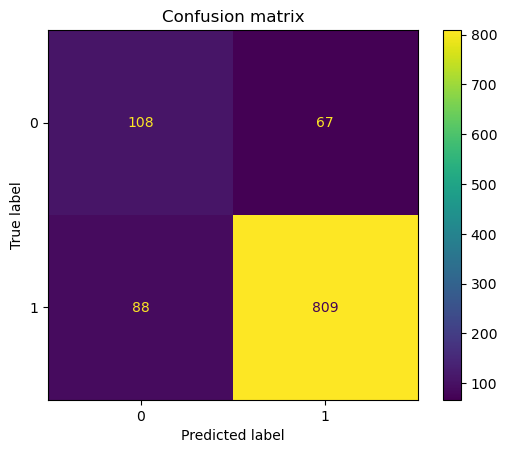

In [121]:
lr = Pipeline([("scale", StandardScaler()), ("log_reg", LogisticRegression(penalty=None, max_iter=10_000))])
lr.fit(X_train_re, y_train_re)
preds    = lr.predict(X_test)

accuracy  = accuracy_score(y_test, preds)
conf      = confusion_matrix(y_test, preds)
#grab true negatives, true positives, false positives, false negatives
tn = conf[0,0]
tp = conf[1,1]
fp = conf[0,1]
fn = conf[1,0]

#precision (positive predictive value): what % of players classified as 1's are true 1's?
precision   = tp/(tp+fp)
#recall (sensitivity): what % of true 1's are classified as 1?
recall      = tp/(tp+fn)
#negative predictive value (NPV): what % of players classified as 0's are true 0's?
npv         = tn/(tn+fn)
#specificity: what % of true 0's are classified as 0?
specificity = tn/(tn+fp)

print(f"Accuracy:    {accuracy:.2f}")
print(f"Precision:   {precision:.2f}")
print(f"Recall:      {recall:.2f}")
print(f"NPV:         {npv:.2f}")
print(f"Specificity: {specificity:.2f}")

ConfusionMatrixDisplay(conf).plot()
plt.title("Confusion matrix")
plt.show()

To briefly summarize: the performance is reasonably good.  The classifier is really good ($\sim 90\%$ precision and recall) at correctly guessing when a player will stay in the league (which is the majority class, about $81\%$ of all rows), and slightly better than random chance when a player is going to be out of the league ($\sim 60\%$ recall and NPV).

Note that we only used stats and salary data!  We could also include predictors like draft position if a player was drafted and whether or not a player has been previously traded or waived.  To see which additional predictors could be useful, we need to **look at the false positives and false negatives** to see why our model is guessing wrong.

## Investigating misclassified rows

Let's add a column to `df` with the model's prediction, `MODEL_PRED`.  Then we can consider false positives and false negatives, and see why they get misclassified.

In [125]:
df["MODEL_PRED"] = lr.predict(df[predictors])

### Inspecting false positives

Let's now look at false positives: players the model think should be in the NBA next season, who don't end up playing.

In [128]:
df.loc[ (df["IN_LEAGUE_NEXT"]==0) & (df["MODEL_PRED"]==1) ].sample(5, random_state=815)

,NAME,PLAYER_ID,SEASON_START,TEAMS_LIST,PLAYER_AGE,EXPERIENCE,POS,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PER,TS_PERCENT,X3P_AR,F_TR,ORB_PERCENT,DRB_PERCENT,TRB_PERCENT,AST_PERCENT,STL_PERCENT,BLK_PERCENT,TOV_PERCENT,USG_PERCENT,OWS,DWS,WS,WS_48,OBPM,DBPM,BPM,VORP,Salary,Percent_team_salary,WAIVED_OFF,WAIVED_REG,WAIVED_POST,RELEASED_OFF,RELEASED_REG,RELEASED_POST,TRADED_OFF,TRADED_REG,TRADED_POST,WAIVED_NEXT_OFF,WAIVED_NEXT_REG,WAIVED_NEXT_POST,RELEASED_NEXT_OFF,RELEASED_NEXT_REG,RELEASED_NEXT_POST,TRADED_NEXT_OFF,TRADED_NEXT_REG,TRADED_NEXT_POST,WAIVED_NEXT_NEXT_OFF,RELEASED_NEXT_NEXT_OFF,TRADED_NEXT_NEXT_OFF,WAIVED_NBA_YEAR,WAIVED_NEXT_NBA_YEAR,RELEASED_NBA_YEAR,RELEASED_NEXT_NBA_YEAR,TRADED_NBA_YEAR,TRADED_NEXT_NBA_YEAR,IN_LEAGUE_NEXT,MODEL_PRED
4383,Kevin McHale,1450,1992,['BOS'],35.0,13,PF,71,0.0,1656.0,298,649,0.459,2.0,18.0,0.111,164,195,0.841,95.0,263.0,358.0,73,16.0,59.0,92.0,126,762,14.4,0.519,0.028,0.300,6.6,17.8,12.2,6.4,0.5,2.2,11.1,21.7,1.2,1.6,2.8,0.082,-0.7,-0.9,-1.7,0.1,3500000.0,0.138795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5790,Laron Profit,1919,2000,['WAS'],23.0,2,PG,35,12.0,605.0,56,142,0.394,7.0,26.0,0.269,33,45,0.733,18.0,46.0,64.0,89,36.0,11.0,46.0,43,152,11.7,0.470,0.183,0.317,3.4,9.1,6.2,23.5,3.1,1.3,22.1,15.3,-0.1,0.4,0.3,0.023,-1.4,0.4,-1.0,0.2,508000.0,0.008598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
9816,Rodney Stuckey,201155,2016,['IND'],31.0,10,PG,39,0.0,696.0,91,244,0.373,19.0,60.0,0.317,80,107,0.748,6.0,78.0,84.0,84,16.0,0.0,53.0,44,281,9.5,0.483,0.246,0.439,1.0,12.4,6.8,17.7,1.2,0.0,15.4,22.2,-0.5,0.4,-0.1,-0.006,-3.2,-1.2,-4.4,-0.4,7000000.0,0.077537,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
15386,Josh Christopher,1630528,2022,['HOU'],21.0,2,SG,64,2.0,786.0,153,329,0.465,21.0,89.0,0.236,45,60,0.750,20.0,51.0,71.0,73,33.0,15.0,60.0,59,372,11.5,0.523,0.271,0.182,2.8,7.2,5.0,14.3,2.0,1.9,14.4,21.9,-0.3,0.3,0.0,-0.001,-3.0,-1.4,-4.3,-0.5,2372160.0,0.017242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
11647,JaJuan Johnson,202707,2011,['BOS'],23.0,1,PF,36,0.0,298.0,54,121,0.446,0.0,0.0,0.000,6,9,0.667,20.0,38.0,58.0,6,5.0,14.0,14.0,25,114,11.4,0.456,0.000,0.074,8.3,14.4,11.5,3.6,0.9,3.6,10.1,22.4,-0.3,0.5,0.2,0.032,-3.3,-0.6,-3.9,-0.1,1042320.0,0.013058,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


Let's look at this case-by-case:
- Kevin McHale was old (35) but still a solid NBA bench guy.  He retired due to injuries in the 1992 season.
- Laron Profit was a fringe NBA guy.  He played a couple seasons with the Wizards, then went overseas for a couple seasons, before coming back to the NBA and playing with the Wizards again and then the Lakers.
- Rodney Stuckey was still productive in the 2016-2017 season, but was injured.  He was waived and then retired due to the injury.
- Josh Christopher was a fringe-NBA guy who bounced between the NBA and the G-league.
- JaJuan Johnson was similar; dropped to G-league then went overseas.


Conclusions:
- It's hard just based on the stats to determine when NBA greats (like McHale, 3x NBA Champ, 7x All-Star, 3x All-Defense) will retire.  They usually do because of injuries, so maybe we include the number of games they played in the previous season?  Maybe just marking them as great players is enough, and we can have the model learn the difference; we could do this by including awards like MVPs, titles, All-Star selections, etc.
- Laron Profit bounced back and forth between the NBA and overseas teams.  Also hard to predict.
- Stucky was productive enough to play, but old and injured.

### Inspecting false negatives

Let's now look at false negatives: players the model thinks should be out of the league, who manage to hang on.

In [132]:
df.loc[ (df["IN_LEAGUE_NEXT"]==1) & (df["MODEL_PRED"]==0) ].sample(5, random_state=815)

,NAME,PLAYER_ID,SEASON_START,TEAMS_LIST,PLAYER_AGE,EXPERIENCE,POS,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PER,TS_PERCENT,X3P_AR,F_TR,ORB_PERCENT,DRB_PERCENT,TRB_PERCENT,AST_PERCENT,STL_PERCENT,BLK_PERCENT,TOV_PERCENT,USG_PERCENT,OWS,DWS,WS,WS_48,OBPM,DBPM,BPM,VORP,Salary,Percent_team_salary,WAIVED_OFF,WAIVED_REG,WAIVED_POST,RELEASED_OFF,RELEASED_REG,RELEASED_POST,TRADED_OFF,TRADED_REG,TRADED_POST,WAIVED_NEXT_OFF,WAIVED_NEXT_REG,WAIVED_NEXT_POST,RELEASED_NEXT_OFF,RELEASED_NEXT_REG,RELEASED_NEXT_POST,TRADED_NEXT_OFF,TRADED_NEXT_REG,TRADED_NEXT_POST,WAIVED_NEXT_NEXT_OFF,RELEASED_NEXT_NEXT_OFF,TRADED_NEXT_NEXT_OFF,WAIVED_NBA_YEAR,WAIVED_NEXT_NBA_YEAR,RELEASED_NBA_YEAR,RELEASED_NEXT_NBA_YEAR,TRADED_NBA_YEAR,TRADED_NEXT_NBA_YEAR,IN_LEAGUE_NEXT,MODEL_PRED
4821,Darnell Mee,1577,1993,['DEN'],23.0,1,SG,38,0.0,285.0,28,88,0.318,5.0,24.0,0.208,12,27,0.444,17.0,18.0,35.0,16,15.0,13.0,18.0,34,73,6.3,0.365,0.273,0.307,6.9,6.8,6.8,8.0,2.6,2.9,15.3,17.6,-0.6,0.4,-0.1,-0.022,-4.3,1.4,-3.0,-0.1,150000.0,0.009311,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5347,Greg Buckner,1761,2007,['MIN'],31.0,9,SG,31,4.0,520.0,45,117,0.385,15.0,50.0,0.300,19,22,0.864,10.0,55.0,65.0,39,21.0,2.0,29.0,63,124,7.2,0.489,0.427,0.188,2.2,12.7,7.2,10.8,2.1,0.3,18.6,13.5,-0.2,0.3,0.1,0.008,-4.4,0.2,-4.1,-0.3,3750000.0,0.054313,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
799,Jud Buechler,146,1993,['GSW'],26.0,4,SF,36,0.0,218.0,42,84,0.500,12.0,29.0,0.414,10,20,0.500,13.0,19.0,32.0,16,8.0,1.0,12.0,24,106,14.9,0.571,0.345,0.238,6.6,9.3,7.9,10.6,1.8,0.3,11.5,19.8,0.4,0.1,0.5,0.112,0.3,-1.0,-0.7,0.1,375000.0,0.019492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6145,Primoz Brezec,2056,2002,['IND'],23.0,2,C,22,1.0,108.0,15,38,0.395,0.0,1.0,0.000,12,20,0.600,13.0,10.0,23.0,4,2.0,4.0,7.0,16,42,10.9,0.449,0.026,0.526,13.5,9.9,11.6,6.0,0.9,2.6,13.0,21.9,0.0,0.1,0.1,0.047,-3.7,-1.8,-5.5,-0.1,805320.0,0.015061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2901,Gary Trent,718,1999,['DAL'],25.0,5,SF,11,11.0,301.0,70,142,0.493,0.0,2.0,0.000,11,21,0.524,20.0,32.0,52.0,22,8.0,3.0,25.0,28,151,14.6,0.499,0.014,0.148,7.2,11.4,9.3,12.7,1.3,0.7,14.2,25.8,-0.1,0.1,0.1,0.014,-0.6,-2.2,-2.8,-0.1,2000000.0,0.049982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Case-by-case:
- Mee played in only 38 games, shot 32% from the field, and 44% from the FT line (as a SG!).  He ended up playing 1 more season with the Nuggets before playing overseas.
- Buckner played one more NBA season after this one.
- Buechler played _many more_ NBA seasons after 1993, including on 3 title teams ('96, '97, '98). He was a career bench guy, and played only 6 minutes in his 36 total games this season.  He was productive in those minutes, though... Unclear why the model thinks he should be out of the league.
- Brezec also played many more years after this season.  Advanced stats don't like him very much, though.
- Gary Trent Sr. hung on for a few more years as well.  He started every game he played this season(!), but ultimately was badly injured.

Conclusions:
- Perhaps we should include a GS/GP column?  This would cover cases like Trent Sr.'s 1999 season, where he was hurt all year but was otherwise a starter.
- It's hard to tell whether a player is particularly good or bad from all of the counting stats.  It would be useful to have counting stats in per-game format, like points per game, assists per game, rebounds per game, etc.
- Perhaps we can use something like $\log(\mathrm{PER}/15)$ as a simple indicator of good or bad, as it will be negative for below-average players (league-average PER is 15).

# TODO

Add more features.  Specifically:
- per-game counting stats
- per-minute counting stats
- starts per games played (should account for injury-prone starters, who play few minutes but start when they can play).

Rescale some features. Specifically:
- consider things like $\log(\mathrm{PER}/15)$, which will be negative for below-average players and positive for above-average ones.